### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

In [4]:
%run init.ipynb
from qiskit import *
nshots = 8192
IBMQ.load_account()
provider= qiskit.IBMQ.get_provider(hub='ibm-q-research-2',group='federal-uni-sant-1',project='main')
device = provider.get_backend('ibmq_bogota')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity

# Implementação de POVMs no IBMQ

Estas notas são baseadas em (Y. S. Yordanov and C. H. W. Barnes, Implementation of a general single-qubit positive operator-valued measure on a circuit-based quantum computer, __Phys. Rev. A 100, 062317 (2019)__).

Os autores obtiveram uma forma de implementar POVMs com $n$ elementos a partir da composição de operações básicas que implementam POVMs com 2 elementos.

Vale notar que na verdade os autores implementam medidas gerais. Ou seja, eles estão interessados em implementar um POVM com elementos $\{E_{j}\}=\{M_{j}^{\dagger}M_{j}\}$ em um sistema preparado inicialmente no estado $|\psi_{0}\rangle$ tal que
\begin{equation}
|\psi_{0}\rangle \xrightarrow[]{\text{obtém }M_{j}} \frac{M_{j}|\psi_{0}\rangle}{\sqrt{Pr(M_{j}|\psi_{0})}}
\end{equation}
com
\begin{equation}
Pr(M_{j}|\psi_{0}) = \langle\psi_{0}|M_{j}^{\dagger}M_{j}|\psi_{0}\rangle = ||M_{j}|\psi_{0}\rangle||^{2}.
\end{equation}

Usando um sistema auxiliar $B$, essa POVM pode ser implementada "unitariamente":
\begin{equation}
U_{AB}|\psi_{0}\rangle_{A}\otimes|0\rangle_{B} = \sum_{j}(M_{j}|\psi_{0}\rangle_{A})\otimes|j\rangle_{B}.
\end{equation}

## POVMs de 1 qubit com 2 elementos
Começamos escrevendo o estado inicial na base computacional
\begin{equation}
|\psi_{0}\rangle = c_{0}|0\rangle_{A}+c_{1}|1\rangle_{A}.
\end{equation}
A ideia é manter em mente que queremos transformar o estado inicial 
\begin{equation}
|\Psi_{0}\rangle = |\psi_{0}\rangle_{A}\otimes|0\rangle_{B}
\end{equation}
em
\begin{equation}
|\Psi_{f}\rangle = (M_{1}|\psi_{0}\rangle_{A})\otimes|o_{1}\rangle_{B} + (M_{2}|\psi_{0}\rangle_{A})\otimes|o_{2}\rangle_{B},
\end{equation}
com $\{|o_{j}\rangle\}_{j=1}^{2}$ estados ortogonais do sistema auxiliar.

A primeira operação do protocolo é uma transformação unitária no sistema $A$:
\begin{align}
|\Psi_{1}\rangle & = (U_{A}\otimes\mathbb{I}_{B})|\Psi_{0}\rangle = (U_{A}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} \\
& := (c_{0}'|0\rangle_{A}+c_{1}'|1\rangle_{A})\otimes|0\rangle_{B}.
\end{align}

O circuito quântico, do protocolo como um todo, está mostrado na figura abaixo. 
<img src = 'qcircuit_povm2.png' width = '500'>

Seguindo aplicamos uma $R_{y}$ controlada, com o estado $|0\rangle$ como ativador. Utilizaremos a notação:

\begin{equation}
C_{R_{y}(\theta)}^{A_{0}\rightarrow B} = |0\rangle_{A}\langle 0|\otimes R_{y}(\theta) + |1\rangle_{A}\langle 1|\otimes \mathbb{I}_{B},
\end{equation}
em que 
\begin{equation}
R_{y}(\theta)=\begin{bmatrix} \cos(\theta/2) & -\sin(\theta/2) \\ \sin(\theta/2) & \cos(\theta/2) \end{bmatrix}.
\end{equation}
Com isso, obteremos o estado
\begin{align}
|\Psi_{2}\rangle & = C_{R_{y}(\theta)}^{A_{0}\rightarrow B}|\Psi_{1}\rangle \\
& = c_{0}'|0\rangle_{A}\otimes\big(\cos(\theta/2)|0\rangle_{B}+\sin(\theta/2)|1\rangle_{B} \big)+c_{1}'|1\rangle_{A}\otimes|0\rangle_{B}.
\end{align}

Depois, aplica-se outra $R_{y}$ controlada, mas com $|1\rangle$ como ativador:
\begin{equation}
C_{R_{y}(\phi)}^{A_{1}\rightarrow B} = |0\rangle_{A}\langle 0|\otimes \mathbb{I}_{B} + |1\rangle_{A}\langle 1|\otimes R_{y}(\phi).
\end{equation}
Assim, obtemos o estado
\begin{align}
|\Psi_{3}\rangle & = C_{R_{y}(\phi)}^{A_{1}\rightarrow B}|\Psi_{2}\rangle \\
& = c_{0}'|0\rangle_{A}\otimes\big(\cos(\theta/2)|0\rangle_{B}+\sin(\theta/2)|1\rangle_{B} \big)+c_{1}'|1\rangle_{A}\otimes\big(\cos(\phi/2)|0\rangle_{B}+\sin(\phi/2)|1\rangle_{B} \big) \\
& = \big(\cos(\theta/2)c_{0}'|0\rangle_{A} + \cos(\phi/2)c_{1}'|1\rangle_{A}\big)\otimes|0\rangle_{B} + \big(\sin(\theta/2)c_{0}'|0\rangle_{A} + \sin(\phi/2)c_{1}'|1\rangle_{A}\big)\otimes|1\rangle_{B} \\
& = (D_{1}U_{A}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (D_{2}U_{A}|\psi_{0}\rangle_{A})\otimes|1\rangle_{B}.
\end{align}

Acima definimos os operadores 
\begin{align}
D_{1} & = \cos(\theta/2)|0\rangle_{A}\langle 0| + \cos(\phi/2)|1\rangle_{A}\langle 1|, \\
D_{2} & = \sin(\theta/2)|0\rangle_{A}\langle 0| + \sin(\phi/2)|1\rangle_{A}\langle 1|,
\end{align}
que são operadores gerais de um qubit, a menos de uma transformação unitária para generalizar os autovetores. Podemos garantir que esses operadores sejam positivos restringindo
\begin{equation}
\theta,\phi\in[0,\pi].
\end{equation}

Seguimos aplicando uma unitária qualquer $V_{1}$ controlada
\begin{equation}
C_{V_{1}}^{B_{0}\rightarrow A} = V_{1}\otimes|0\rangle_{B}\langle 0| + \mathbb{I}\otimes|1\rangle_{B}\langle 1|,
\end{equation}
obtendo o estado
\begin{align}
|\Psi_{4}\rangle & = C_{V_{1}}^{B_{0}\rightarrow A}|\Psi_{3}\rangle \\
& = (V_{1}D_{1}U_{A}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (D_{2}U_{A}|\psi_{0}\rangle_{A})\otimes|1\rangle_{B}.
\end{align}

Por fim, aplicamos uma unitária qualquer $V_{2}$ controlada
\begin{equation}
C_{V_{2}}^{B_{1}\rightarrow A} = \mathbb{I}_{A}\otimes|0\rangle_{B}\langle 0| + V_{2}\otimes|1\rangle_{B}\langle 1|,
\end{equation}
obtendo o estado
\begin{align}
|\Psi_{5}\rangle & = C_{V_{2}}^{B_{1}\rightarrow A}|\Psi_{4}\rangle \\
& = (V_{1}D_{1}U_{A}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (V_{2}D_{2}U_{A}|\psi_{0}\rangle_{A})\otimes|1\rangle_{B} \\
& = (M_{1}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (M_{2}|\psi_{0}\rangle_{A})\otimes|1\rangle_{B}.
\end{align}

Pelo teorema da _decomposição em valores singulares_, temos que para qualquer matriz $A$, existem matrizes unitárias $U$ e $W$ e uma matriz $D$ positiva e diagonal na base padrão $\{|j\rangle\}$ tais que
\begin{equation}
A = UDW.
\end{equation}
Portanto, o circuito acima é tal que temos duas matrizes "gerais"
\begin{align}
& M_{1} = V_{1}D_{1}U_{A}, \\
& M_{2} = V_{2}D_{2}U_{A}.
\end{align}
A possível limitação de $U_{A}$ aparecer nas duas equações é importante para que a relação de completeza dos operadores de medida seja satisfeita:
\begin{align}
\sum_{j}M_{j}^{\dagger}M_{j} & = M_{1}^{\dagger}M_{1} + M_{2}^{\dagger}M_{2} \\
& = U_{A}^{\dagger}D_{1}^{\dagger}V_{1}^{\dagger}V_{1}D_{1}U_{A} + U_{A}^{\dagger}D_{2}^{\dagger}V_{2}^{\dagger}V_{2}D_{2}U_{A} \\
& = U_{A}^{\dagger}D_{1}^{2}U_{A} + U_{A}^{\dagger}D_{2}^{2}U_{A} = U_{A}^{\dagger}\big(D_{1}^{2}+D_{2}^{2}\big)U_{A} \\
& = U_{A}^{\dagger}\big(\cos^{2}(\theta/2)|0\rangle_{A}\langle 0| + \cos^{2}(\phi/2)|1\rangle_{A}\langle 1| + \sin^{2}(\theta/2)|0\rangle_{A}\langle 0| + \sin^{2}(\phi/2)|1\rangle_{A}\langle 1|\big)U_{A} \\
& = U_{A}^{\dagger}\big(|0\rangle_{A}\langle 0| + |1\rangle_{A}\langle 1|\big)U_{A} = U_{A}^{\dagger}U_{A} \\
& = \mathbb{I}_{A}.
\end{align}

### Experimento no IBMQ

Como exemplo, usamos primeiramente operadores de medida definidos por 
\begin{equation}
\theta=\phi=\pi/4 \text{, } V_{1}=V_{2} = \mathbb{I} \text{ e } U_{A} = \frac{1}{\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}=H.
\end{equation}
Assim
\begin{align}
D_{1}(\pi/8) = 2^{-1}\sqrt{2+\sqrt{2}}\mathbb{I} \text{ e } D_{2}(\pi/8) = 2^{-1}\sqrt{2-\sqrt{2}}\mathbb{I}
\end{align}
e
\begin{align}
& M_{1} = V_{1}D_{1}(\pi/8)U_{A} = \frac{1}{2}\sqrt{1+1/\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}, \\
& M_{2} = V_{2}D_{2}(\pi/8)U_{A} = \frac{1}{2}\sqrt{1-1/\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}.
\end{align}
Pode-se verificar que esses operadores não são projetores, mas são operadores de medida bem definidos.

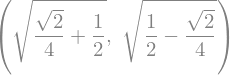

In [10]:
cos(pi/8), sin(pi/8)

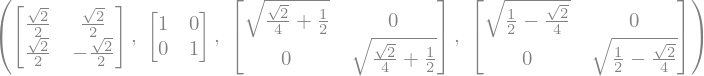

In [11]:
U = (1/sqrt(2))*Matrix([[1,1],[1,-1]]); V1 = Matrix([[1,0],[0,1]]); V2 = V1
D1 = Matrix([[cos(pi/8),0],[0,cos(pi/8)]]); D2 = Matrix([[sin(pi/8),0],[0,sin(pi/8)]])
U, U*U.T, D1, D2

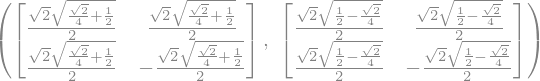

In [12]:
M1 = V1*D1*U; M2 = V2*D2*U; M1, M2

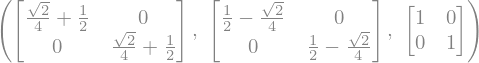

In [14]:
M1*M1, M2*M2, M1*M1 + M2*M2 # não são projetores, mas são operadores de medida

Vamos usar o estado inicial
\begin{equation}
|\psi_{0}\rangle_{A} = |0\rangle_{A}.
\end{equation}

Com isso, vem que as probabilidade dos diferentes resultados da medida são:
\begin{align}
Pr(M_{1}|0) & = \langle 0|M_{1}^{\dagger}M_{1}|0\rangle = \langle 0|2^{-2}(2+\sqrt{2})H^{\dagger}H|0\rangle = 2^{-1}(1+\sqrt{2}/2)\langle 0|0\rangle \\
& = 2^{-1}(1+1/\sqrt{2}) \approx 0.85, \\
Pr(M_{2}|0) & = \langle 0|M_{2}^{\dagger}M_{2}|0\rangle = \langle 0|2^{-2}(2-\sqrt{2})H^{\dagger}H|0\rangle = 2^{-1}(1-\sqrt{2}/2)\langle 0|0\rangle \\
& = 2^{-1}(1-1/\sqrt{2}) \approx 0.15.
\end{align}

In [11]:
2*float((1/4)*(1+1/sqrt(2))), 2*float((1/4)*(1-1/sqrt(2)))

O estado global é
\begin{align}
|\Psi_{5}\rangle & = (M_{1}|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (M_{2}|\psi_{0}\rangle_{A})\otimes|1\rangle_{B} \\
& = (2^{-1}\sqrt{2+\sqrt{2}}H|0\rangle_{A})\otimes|0\rangle_{B} + (2^{-1}\sqrt{2-\sqrt{2}}H|0\rangle_{A})\otimes|1\rangle_{B} \\
& = (2^{-1}\sqrt{2+\sqrt{2}}|+\rangle_{A})\otimes|0\rangle_{B} + (2^{-1}\sqrt{2-\sqrt{2}}|+\rangle_{A})\otimes|1\rangle_{B} \\
& = 2^{-1}\sqrt{1+1/\sqrt{2}}|00\rangle_{AB} + 2^{-1}\sqrt{1+1/\sqrt{2}}|10\rangle_{AB} + 2^{-1}\sqrt{1-1/\sqrt{2}}|01\rangle_{AB} + 2^{-1}\sqrt{1-1/\sqrt{2}}|11\rangle_{AB}.
\end{align}
Temos assim que 
\begin{align}
Pr(M_{1}|0_{A}) & = Pr(0_{B}|\Psi_{5}) = Pr(00_{AB}|\Psi_{5}) + Pr(10_{AB}|\Psi_{5}) \\
& = 2\big(2^{-2}(1+1/\sqrt{2})\big) \approx 0.85, \\
Pr(M_{2}|0_{A}) & = Pr(1_{B}|\Psi_{5}) = Pr(01_{AB}|\Psi_{5}) + Pr(11_{AB}|\Psi_{5}) \\
& = 2\big(2^{-2}(1-1/\sqrt{2})\big) \approx 0.15.
\end{align}

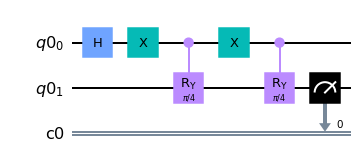

In [8]:
qr = QuantumRegister(2); cr = ClassicalRegister(1); qc = QuantumCircuit(qr, cr)
qc.h(qr[0]); qc.x(qr[0]); qc.cry(math.pi/4, 0, 1); qc.x(qr[0]); qc.cry(math.pi/4, 0, 1)
# V1=V2=I
qc.measure(1,0)
qc.draw(output = 'mpl')

In [35]:
job_sim = execute(qc, backend = simulator, shots = nshots)
job_exp = execute(qc, backend = device, shots = nshots)
job_monitor(job_exp)

Job Status: job has successfully run


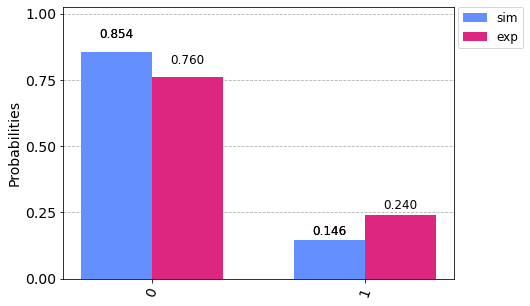

In [40]:
plot_histogram([job_sim.result().get_counts(), job_exp.result().get_counts()], 
                legend = ['sim', 'exp'])

### Sobre o problema inverso
Desprezando alguns detalhes (parâmetros), podemos escrever uma matriz unitária $2\times 2$ qualquer como
\begin{align}
U & = \begin{bmatrix}e^{i\xi}\cos\gamma & e^{i\eta}\sin\gamma \\ -e^{-i\eta}\sin\gamma & e^{-i\xi}\cos\gamma. \end{bmatrix}
\end{align}
Os vetores linha(coluna) desta matriz formam um conjunto ortonormal e $\det(U)=1$.
Para, dados os operadores de medida $M_{j}$, gostaríamos de obter os parâmetros reais que determinam as matrizes unitárias que devemos usar. Mesmo no caso mais simples de medidas gerais com 2 elementos em um qubit, precisamos de 3 unitárias, e portanto 9 parâmetros, além dos 2 ângulos nas matrizes diagonais. Resolver esse problema involve resolver um sistema de equações não lineares. Obteremos esse sistema na sequência.

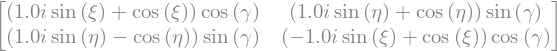

In [37]:
def U(xi, et, ga):
    return Matrix([[(cos(xi)+1j*sin(xi))*cos(ga), (cos(et)+1j*sin(et))*sin(ga)],
                    [-(cos(et)-1j*sin(et))*sin(ga), (cos(xi)-1j*sin(xi))*cos(ga)]])
xi, et, ga = symbols('xi eta gamma'); U(xi, et, ga)

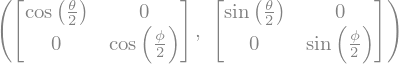

In [38]:
def D1(th, ph):
    return Matrix([[cos(th/2),0],[0,cos(ph/2)]])
def D2(th, ph):
    return Matrix([[sin(th/2),0],[0,sin(ph/2)]])
th,ph = symbols('theta phi'); D1(th, ph), D2(th, ph)

Teremos que
\begin{align}
& M_{1} = V_{1}D_{1}U = V_{1}(\xi_{1},\eta_{1},\gamma_{1})D_{1}(\theta,\phi)U(\xi_{2},\eta_{2},\gamma_{2}) = \frac{1}{2}\sqrt{1+1/\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}, \\
& M_{2} = V_{2}D_{2}U_{A}  = V_{2}(\xi_{3},\eta_{3},\gamma_{3})D_{2}(\theta,\phi)U(\xi_{2},\eta_{2},\gamma_{2}) = \frac{1}{2}\sqrt{1-1/\sqrt{2}}\begin{bmatrix}1&1\\1&-1\end{bmatrix}.
\end{align}
Ou seja, temos 13 incógnitas e 16 equações (8 pra parte real e 8 para a parte imaginária). O sistema de equações a ser resolvido é não linear e bem complicado de resolver até numericamente. Port
anto esse caminho e a aplicação geral desse método parece difícil para um caso geral, embora se possa inferir as unitárias em alguns casos particulares.

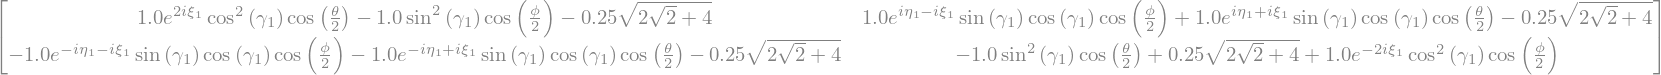

In [41]:
xi1,et1,ga1,xi2,et2,ga2,xi3,et3,ga3 = symbols('xi_1 eta_1 gamma_1 xi_2 eta_2 gamma_2 xi_3 eta_3 gamma_3')
simplify(U(xi1,et1,ga1)*D1(th,ph)*U(xi2,et2,ga2) - (1/2)*sqrt(1+1/sqrt(2))*Matrix([[1,1],[1,-1]]))

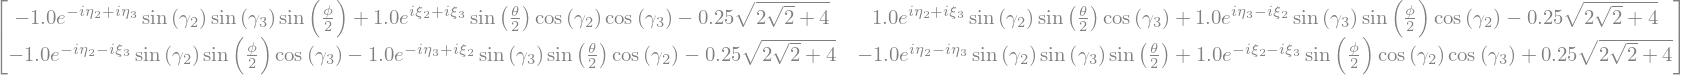

In [42]:
simplify(U(xi3,et3,ga3)*D2(th,ph)*U(xi2,et2,ga2) - (1/2)*sqrt(1+1/sqrt(2))*Matrix([[1,1],[1,-1]]))

## POVMs de 1 qubit com $n$ elementos

Pode-se compor o circuito acima para implementar um POVM com $n$ elementos, como mostrado na figura abaixo:

<img src = 'qcircuit_povmn.png' width = '800'>

Os autores dizem que este circuito geral prepara o estado
\begin{equation}
|\Psi\rangle = \sum_{j=1}^{n-1}(M_{j}|\psi_{0}\rangle)\otimes|o_{1}^{(j)}\rangle + (M_{n}|\psi_{0}\rangle)\otimes|o_{2}^{(n-1)}\rangle,
\end{equation}
com 
\begin{equation}
M_{j} = 
\begin{cases} 
V_{1}^{(1)}D_{1}^{(1)}U \text{, para } j=1, \\
V_{1}^{(j)}D_{1}^{(j)}\Pi_{k=1}^{j-1}V_{2}^{(k)}D_{2}^{(k)}U \text{, para } 1<j<n, \\
\Pi_{k=1}^{n-1}V_{2}^{(k)}D_{2}^{(k)}U \text{, para } j = n.
\end{cases}
\end{equation}

### Caso $n=3$: <br>
Depois da aplicação da porta $U$ e do módulo 1, teremos obtido o estado
\begin{equation}
|\Phi_{1}\rangle = \big((V_{1}^{(1)}D_{1}^{(1)}U|\psi_{0}\rangle_{A})\otimes|0\rangle_{B} + (V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A})\otimes|1\rangle_{B}\big)\otimes|0\rangle_{C},
\end{equation}
com 
\begin{align}
& D_{1}^{(1)} = \cos(\theta_{1}/2)|0\rangle_{A}\langle 0| + \cos(\phi_{1}/2)|1\rangle_{A}\langle 1| \\
& D_{2}^{(1)} = \sin(\theta_{1}/2)|0\rangle_{A}\langle 0| + \sin(\phi_{1}/2)|1\rangle_{A}\langle 1|.
\end{align}

Para ter algo parecido com o caso $n=2$, vamos definir
\begin{equation}
V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A} =: c|0\rangle_{A} + d|1\rangle_{A}
\end{equation}
e
\begin{equation}
V_{1}^{(1)}D_{1}^{(1)}U =: M_{1}
\end{equation}
para escrever
\begin{align}
|\Phi_{1}\rangle & = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  (c|0\rangle_{A} + d|1\rangle_{A})\otimes|10\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  c|01\rangle_{AB}\otimes|0\rangle_{C} + d|11\rangle_{AB}\otimes|0\rangle_{C}.
\end{align}

Seguindo, aplicamos as rotações controladas 
\begin{align}
C^{A_{0}B_{1}\rightarrow C}_{R_{y}(\theta_{2})} = |0\rangle_{A}\langle 0|\otimes|1\rangle_{B}\langle 1|\otimes R_{y}(\theta_{2}) + (|0\rangle_{A}\langle 0|\otimes|0\rangle_{B}\langle 0|+|1\rangle_{A}\langle 1|\otimes|0\rangle_{B}\langle 0|+|1\rangle_{A}\langle 1|\otimes|1\rangle_{B}\langle 1|)\otimes\mathbb{I}_{C}.
\end{align}
e
\begin{align}
C^{A_{1}B_{1}\rightarrow C}_{R_{y}(\phi_{2})} = |1\rangle_{A}\langle 1|\otimes|1\rangle_{B}\langle 1|\otimes R_{y}(\phi_{2}) + (|0\rangle_{A}\langle 0|\otimes|0\rangle_{B}\langle 0|+|1\rangle_{A}\langle 1|\otimes|0\rangle_{B}\langle 0|+|0\rangle_{A}\langle 0|\otimes|1\rangle_{B}\langle 1|)\otimes\mathbb{I}_{C}.
\end{align}
para obter
\begin{align}
|\Phi_{2}\rangle & = C^{A_{1}B_{1}\rightarrow C}_{R_{y}(\phi_{2})}C^{A_{0}B_{1}\rightarrow C}_{R_{y}(\theta_{2})}|\Phi_{1}\rangle \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  c|01\rangle_{AB}\otimes R_{y}(\theta_{2}/2)|0\rangle_{C} + d|11\rangle_{AB}\otimes R_{y}(\phi_{2}/2)|0\rangle_{C} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  c|01\rangle_{AB}\otimes \big(\cos(\theta_{2}/2)|0\rangle_{C}+\sin(\theta_{2}/2)|1\rangle_{C}\big) + d|11\rangle_{AB}\otimes \big(\cos(\phi_{2}/2)|0\rangle_{C}+\sin(\phi_{2}/2)|1\rangle_{C}\big) \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  \big(c\cos(\theta_{2}/2)|0\rangle_{A}+d\cos(\phi_{2}/2)|1\rangle_{A}\big)\otimes|10\rangle_{BC} +  \big(c\sin(\theta_{2}/2)|0\rangle_{A}+d\sin(\phi_{2}/2)|1\rangle_{A}\big)\otimes|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  D_{1}^{(2)}\big(c|0\rangle_{A}+d|1\rangle_{A}\big)\otimes|10\rangle_{BC} +  D_{2}^{(2)}\big(c|0\rangle_{A}+d|1\rangle_{A}\big)\otimes|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|10\rangle_{BC} +  D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|11\rangle_{BC} \\
\end{align}
com  
\begin{align}
& D_{1}^{(2)} := \cos(\theta_{2}/2)|0\rangle_{A}\langle 0| + \cos(\phi_{2}/2)|1\rangle_{A}\langle 1|, \\
& D_{2}^{(2)} := \sin(\theta_{2}/2)|0\rangle_{A}\langle 0| + \sin(\phi_{2}/2)|1\rangle_{A}\langle 1|.
\end{align}

Aplicando $C_{V_{1}^{(2)}}^{B_{1}C_{0}\rightarrow A}$ e $C_{V_{2}^{(2)}}^{B_{1}C_{1}\rightarrow A}$ obteremos
\begin{align}
|\Phi_{3}\rangle & = C_{V_{1}^{(2)}}^{B_{1}C_{0}\rightarrow A}C_{V_{2}^{(2)}}^{B_{1}C_{1}\rightarrow A}|\Phi_{2}\rangle \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|10\rangle_{BC} +  V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}\otimes|10\rangle_{BC} +  M_{3}|\psi_{0}\rangle_{A}\otimes|11\rangle_{BC}
\end{align}
com
\begin{align}
& M_{1} := V_{1}^{(1)}D_{1}^{(1)}U, \\
& M_{2} := V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U, \\
& M_{3} := V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U.
\end{align}

Verificação da relação de completeza:
\begin{align}
\sum_{j}M_{j}^{\dagger}M_{j} & = M_{1}^{\dagger}M_{1} + M_{2}^{\dagger}M_{2} + M_{3}^{\dagger}M_{3} \\
& = U^{\dagger}D_{1}^{(1)}(V_{1}^{(1)})^{\dagger}V_{1}^{(1)}D_{1}^{(1)}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}D_{1}^{(2)}(V_{1}^{(2)})^{\dagger}V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U \\
& + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}D_{2}^{(2)}(V_{2}^{(2)})^{\dagger}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U \\
& = U^{\dagger}(D_{1}^{(1)})^{2}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}(D_{1}^{(2)})^{2}V_{2}^{(1)}D_{2}^{(1)}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}(D_{2}^{(2)})^{2}V_{2}^{(1)}D_{2}^{(1)}U \\
& = U^{\dagger}(D_{1}^{(1)})^{2}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}\big((D_{1}^{(2)})^{2}+(D_{2}^{(2)})^{2}\big)V_{2}^{(1)}D_{2}^{(1)}U \\
& = U^{\dagger}(D_{1}^{(1)})^{2}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}V_{2}^{(1)}D_{2}^{(1)}U \\
& = U^{\dagger}(D_{1}^{(1)})^{2}U + U^{\dagger}(D_{2}^{(1)})^{2}U = U^{\dagger}\big((D_{1}^{(1)})^{2}+(D_{2}^{(1)})^{2}\big)U \\
& = U^{\dagger}U = \mathbb{I}.
\end{align}

### Experimento no IBMQ
Como um estado geral de um qubit pode ser escrito como
\begin{equation}
|\psi(\theta,\phi)\rangle = \cos(\theta/2)|0\rangle + e^{i\phi}\sin(\theta/2)|1\rangle,
\end{equation}
vemos que
\begin{align}
& |\psi(0,0)\rangle=|0\rangle, \\
& |\psi(2\pi/3,0)\rangle = (|0\rangle + \sqrt{3}|1\rangle)/2, \\
& |\psi(4\pi/3,0)\rangle = -(|0\rangle - \sqrt{3}|1\rangle)/2,
\end{align}
que "correspondem" aos elementos do POVM $\{M_{1},M_{2},M_{3}\}$, respectivamente. Ou seja, este POVM "corresponde" a direções separadas por $120^{\circ}$ no plano $xz$ da esfera de Bloch.

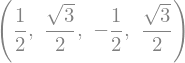

In [4]:
cos(pi/3), sin(pi/3), cos(2*pi/3), sin(2*pi/3)

Primeiro vamos analisar a proposta de operadores colocada no artigo referência:
\begin{align}
& M_{1}=\sqrt{2/3}|0\rangle\langle 0|, \\
& M_{2}=(1/4\sqrt{6})(|0\rangle+\sqrt{3}|1\rangle)(\langle0|+\sqrt{3}\langle1|), \\
& M_{3}=(1/4\sqrt{6})(|0\rangle-\sqrt{3}|1\rangle)(\langle0|-\sqrt{3}\langle1|).
\end{align}
Vemos com o código abaixo que esses operadores não satisfazem a relação de completeza $\sum_{j}M_{j}^{\dagger}M_{I}=\mathbb{I}$.

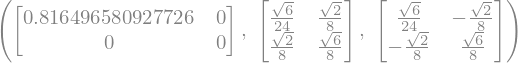

In [116]:
M1 = sqrt(2/3)*Matrix([[1,0],[0,0]])
M2 = (1/(4*sqrt(6)))*Matrix([[1,sqrt(3)],[sqrt(3),3]])
M3 = (1/(4*sqrt(6)))*Matrix([[1,-sqrt(3)],[-sqrt(3),3]])
M1,M2,M3

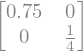

In [117]:
M1.T*M1 + M2.T*M2 + M3.T*M3

Consideremos então uma medida geral com os seguintes elementos
\begin{align}
& M_{1} = a|0\rangle\langle 0|, \\
& M_{2} = b|\psi(2\pi/3,0)\rangle\langle\psi(2\pi/3,0)|, \\
& M_{2} = c|\psi(4\pi/3,0)\rangle\langle\psi(2\pi/3,0)|.
\end{align}
A relação de completeza deve ser satisfeita:
\begin{align}
\mathbb{I} & =: \sum_{j}M_{j}^{\dagger}M_{j} \\
& = M_{1}^{\dagger}M_{1} + M_{2}^{\dagger}M_{2} + M_{3}^{\dagger}M_{3} = M_{1}^{2} + M_{2}^{2} + M_{3}^{2} \\
& = a^{2}|0\rangle\langle 0| + b^{2}|\psi(2\pi/3,0)\rangle\langle\psi(2\pi/3,0)| + c^{2}|\psi(4\pi/3,0)\rangle\langle\psi(2\pi/3,0)| \\
& = a^{2}|0\rangle\langle 0| + \frac{b^{2}}{4}\big(|0\rangle+\sqrt{3}|1\rangle\big)\big(\langle 0|+\sqrt{3}\langle1|\big) + \frac{c^{2}}{4}\big(|0\rangle-\sqrt{3}|1\rangle\big)\big(\langle 0|-\sqrt{3}\langle1|\big) \\
& = a^{2}|0\rangle\langle 0| + \frac{b^{2}}{4}\big(|0\rangle\langle 0| + \sqrt{3}|0\rangle\langle 1| + \sqrt{3}|1\rangle\langle 0| + 3|1\rangle\langle 1|\big) \\
& \hspace{0.5cm} + \frac{c^{2}}{4}\big(|0\rangle\langle 0| - \sqrt{3}|0\rangle\langle 1| - \sqrt{3}|1\rangle\langle 0| + 3|1\rangle\langle 1|\big)  \\
& = a^{2}|0\rangle\langle 0| + 2\frac{b^{2}}{4}\big(|0\rangle\langle 0| + 3|1\rangle\langle 1|\big) = (a^{2}+b^{2}/2)|0\rangle\langle 0| + (3b^{2}/2)|1\rangle\langle 1|, \\
\end{align}
em que fizemos $c=b$. Devemos ter portanto
\begin{align}
& (3b^{2}/2) = 1 \ \therefore\ b = \sqrt{2/3}, \\
& \therefore\ a^{2}+b^{2}/2 = a^{2}+(2/3)/2 = 1 \ \therefore\ a = \sqrt{1-1/3}=\sqrt{2/3}.
\end{align}

Obtemos assim
\begin{align}
& M_{1} = \sqrt{2/3}|0\rangle\langle 0| = \sqrt{\frac{2}{3}}\begin{bmatrix}1&0\\0&0\end{bmatrix}, \\
& M_{2} = \sqrt{\frac{2}{3}}|\psi(2\pi/3,0)\rangle\langle\psi(2\pi/3,0)| = \frac{1}{4}\sqrt{\frac{2}{3}}\begin{bmatrix}1&\sqrt{3}\\\sqrt{3}&3\end{bmatrix}, \\
& M_{2} = \sqrt{\frac{2}{3}}|\psi(4\pi/3,0)\rangle\langle\psi(2\pi/3,0)| = \frac{1}{4}\sqrt{\frac{2}{3}}\begin{bmatrix}1&-\sqrt{3}\\-\sqrt{3}&3\end{bmatrix}.
\end{align}

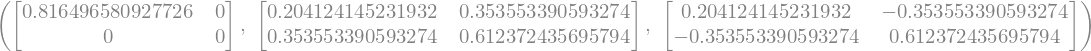

In [120]:
M1 = sqrt(2/3.)*Matrix([[1,0],[0,0]]); M2 = sqrt(2/3.)*(1/4)*Matrix([[1,sqrt(3.)],[sqrt(3.),3]])
M3 = sqrt(2/3.)*(1/4)*Matrix([[1,-sqrt(3.)],[-sqrt(3.),3]])
M1, M2, M3

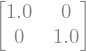

In [122]:
M1.T*M1 + M2.T*M2 + M3.T*M3

Novamente vamos calcular as probabilidades para um estado preparado $|\psi_{0}\rangle:=|0\rangle$:
\begin{align}
Pr(M_{1}|0) & = \langle 0|M_{1}^{\dagger}M_{1}|0\rangle = 2/3 \approx 0.66666666, \\
Pr(M_{2}|0) & = \langle 0|M_{2}^{\dagger}M_{2}|0\rangle = (2/3)|\langle 0|\psi(2\pi/3,0)\rangle|^{2} = (2/3)(1/4) = 1/6 \approx 0.16666666, \\
Pr(M_{3}|0) & = \langle 0|M_{3}^{\dagger}M_{3}|0\rangle = (2/3)|\langle 0|\psi(4\pi/3,0)\rangle|^{2} = (2/3)(1/4) = 1/6 \approx 0.16666666.
\end{align}

In [9]:
2/3, 1/6, 2/3+2*(1/6)

Nesse caso, seguindo nossa __referência principal__, escolhemos
\begin{align}
& U = \mathbb{I}, V_{1}^{(1)} = \mathbb{I} \text{, } V_{2}^{(1)} = \frac{1}{\sqrt{2}}\begin{bmatrix}1&1\\-1&1\end{bmatrix}, \\
& V_{1}^{(2)} = \frac{1}{2}\begin{bmatrix}1&-\sqrt{3}\\\sqrt{3}&1\end{bmatrix} \text{, } V_{2}^{(2)} = -\frac{1}{2}\begin{bmatrix}\sqrt{3}&-1\\1&\sqrt{3}\end{bmatrix}, \\
& \theta_{1} = \arccos(\sqrt{2/3}) \text{, } \phi_{1} = \pi/2 \text{, } \theta_{2} = 0 \text{, } \phi_{2} = \pi/2.
\end{align}
Na sequência fui mudando os valores dos ângulos e as unitárias, pois essas não nos levam ao resultado correto.

In [127]:
#th1 = acos(sqrt(2/3)); ph1 = pi; th2 = pi/2; ph2 = pi/2
D11 = Matrix([[sqrt(2/3),0],[0,0]])
D21 = Matrix([[sqrt(1/3),0],[0,1]]) 
D12 = Matrix([[1/sqrt(2),0],[0,1/sqrt(2)]])
D22 = Matrix([[1/sqrt(2),0],[0,1/sqrt(2)]])
U = Matrix([[1,0],[0,1]])
V11 = Matrix([[1,0],[0,1]])
V21 = (1/sqrt(2))*Matrix([[1,1],[-1,1]])
V12 = (1/2)*Matrix([[1,-sqrt(3)],[sqrt(3),1]])
V22 = -(1/2)*Matrix([[sqrt(3),-1],[1,sqrt(3)]])

In [128]:
M1 = V11*D11*U
np.array(M1).astype(np.float64), np.array(Matrix([[sqrt(2/3),0],[0,0]])).astype(np.float64)

(array([[0.81649658, 0.        ],
        [0.        , 0.        ]]),
 array([[0.81649658, 0.        ],
        [0.        , 0.        ]]))

In [129]:
M2 = V12*D12*V21*D21*U
np.array(M2).astype(np.float64), np.array((1/4)*sqrt(2/3)*Matrix([[1,sqrt(3)],[sqrt(3),3]])).astype(np.float64)
# não é o resultado que precisamos

(array([[ 0.39433757, -0.1830127 ],
        [ 0.10566243,  0.6830127 ]]),
 array([[0.20412415, 0.35355339],
        [0.35355339, 0.61237244]]))

In [130]:
M3 = V22*D22*V21*D21*U
np.array(M3).astype(np.float64), np.array((1/4)*sqrt(2/3)*Matrix([[1,-sqrt(3)],[-sqrt(3),3]])).astype(np.float64)
# não é o resultado que precisamos

(array([[-0.39433757, -0.1830127 ],
        [ 0.10566243, -0.6830127 ]]),
 array([[ 0.20412415, -0.35355339],
        [-0.35355339,  0.61237244]]))

In [61]:
np.array(M1.T*M1 + M2.T*M2 + M3.T*M3).astype(np.float64) # esta ok a relacao de completeza

array([[ 1.00000000e+000, -3.69319145e-127],
       [-3.69319145e-127,  1.00000000e+000]])

A seguir precisaremos da porta geral de um qubit,
\begin{equation}
U(\theta,\phi,\lambda) = \begin{bmatrix} \cos(\theta/2) & -e^{i\lambda}\sin(\theta/2) \\ e^{i\phi}\sin(\theta/2) & e^{i(\phi+\lambda)}\cos(\theta/2)\end{bmatrix},
\end{equation}
aplicada de forma comtrolada:
\begin{equation}
CU(\theta,\phi,\lambda,\gamma) = |0\rangle\langle 0 |\otimes I + |1\rangle\langle 1|\otimes e^{i\gamma}U(\theta,\phi,\lambda).
\end{equation}
Precisaremos aplicar
\begin{align}
V_{2}^{(1)} & = \frac{1}{\sqrt{2}}\begin{bmatrix}1&1\\-1&1\end{bmatrix} = U(\pi/2,\pi,\pi), \\
V_{1}^{(2)} & = \frac{1}{2}\begin{bmatrix}1&-\sqrt{3}\\\sqrt{3}&1\end{bmatrix} = U(2\pi/3,0,0), \\
V_{2}^{(2)} & = -\frac{1}{2}\begin{bmatrix}\sqrt{3}&-1\\1&\sqrt{3}\end{bmatrix} = U(4\pi/3,0,0).
\end{align}

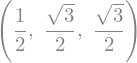

In [89]:
cos(pi/3), sin(pi/3), cos(pi/6)

In [2]:
def qc_ry(th):
    qr = QuantumRegister(1); qc = QuantumCircuit(qr, name = 'RY')
    qc.ry(th, 0)
    return qc
def qc_u(th,ph,lb):
    qr = QuantumRegister(1); qc = QuantumCircuit(qr, name = 'U')
    qc.u(th,ph,lb, 0)
    return qc

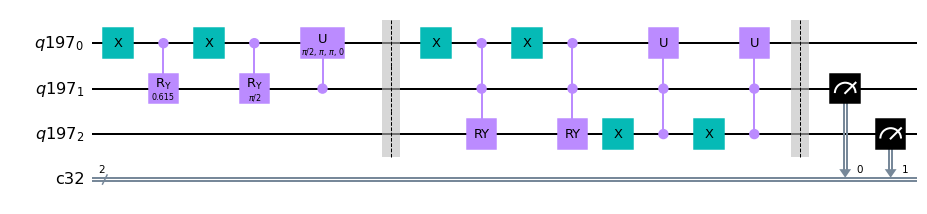

In [133]:
qr = QuantumRegister(3); cr = ClassicalRegister(2); qc = QuantumCircuit(qr, cr)
# U = I
qc.x(qr[0]); qc.cry(math.acos(math.sqrt(2/3)), 0, 1); qc.x(qr[0]); qc.cry(math.pi/2, 0, 1)
# V11 = I
qc.cu(math.pi/2,math.pi,math.pi,0, 1,0)
qc.barrier()
qc_ry_ = qc_ry(0); ccry = qc_ry_.to_gate().control(2) # cria a ctrl-ctrl-RY
qc.x(0); qc.append(ccry, [0,1,2]); qc.x(0)
qc_ry_ = qc_ry(math.pi/2); ccry = qc_ry_.to_gate().control(2)
qc.append(ccry, [0,1,2]) # os primeiros sao o controle, os ultimos sao o target
qc.x(2)
qc_u_ = qc_u(2*math.pi/3,0,0); ccu = qc_u_.to_gate().control(2)
qc.append(ccu, [1,2,0])
qc.x(2)
qc_u_ = qc_u(4*math.pi/3,0,0); ccu = qc_u_.to_gate().control(2)
qc.append(ccu, [1,2,0])
qc.barrier()
qc.measure(1,0); qc.measure(2,1)
qc.draw(output = 'mpl')

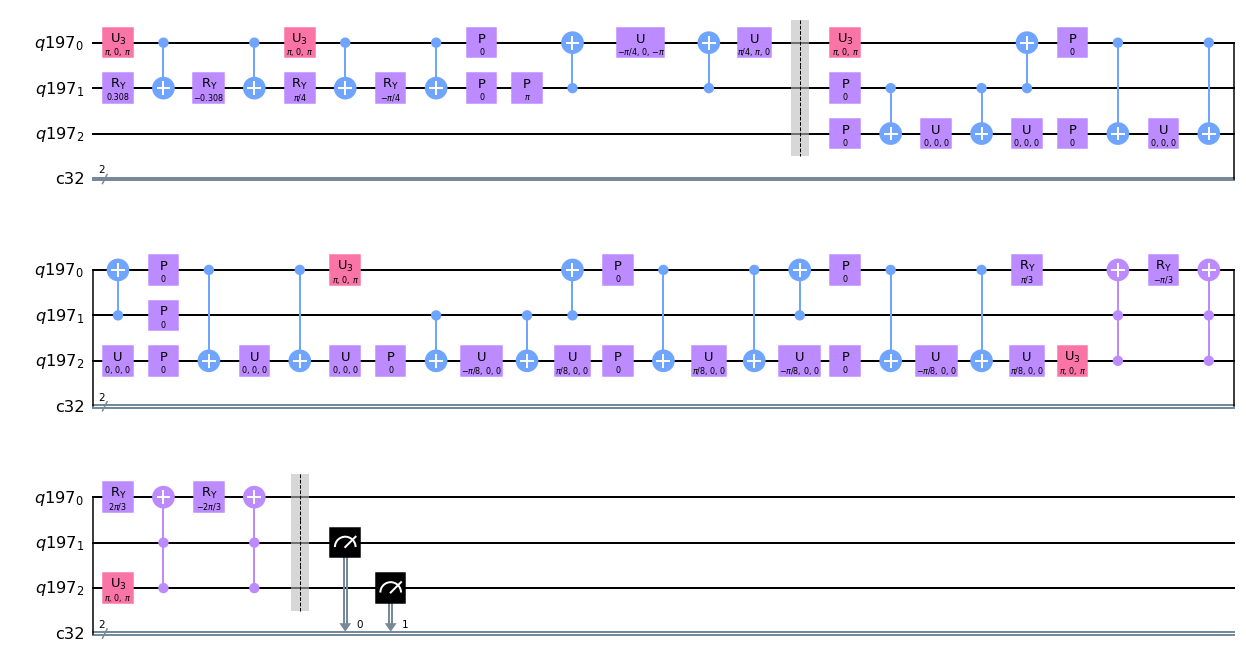

In [134]:
qc.decompose().draw(output = 'mpl')

In [113]:
job_sim = execute(qc, backend = simulator, shots = nshots)
job_exp = execute(qc, backend = device, shots = nshots)
job_monitor(job_exp)

Job Status: job has successfully run


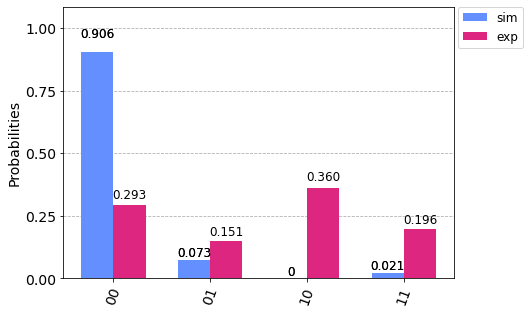

In [114]:
plot_histogram([job_sim.result().get_counts(), job_exp.result().get_counts()], 
                legend = ['sim', 'exp'])

### Exercício
Analogamente ao que fizemos para $n=2$ e $n=3$, obtenha os operadores de medida $M_{j}$ para $\mathbf{n=4}$ e verifique a relação de completeza.

_SOL._ Começamos com o estado
\begin{align}
|\Xi_{1}\rangle & = \big(V_{1}^{(1)}D_{1}^{(1)}U|\psi_{0}\rangle_{A}|00\rangle_{BC} +  V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|10\rangle_{BC} +  V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}\otimes|11\rangle_{BC} \big)\otimes |0\rangle_{D} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  \big(e|0\rangle_{A}+f|1\rangle_{A}\big)\otimes|11\rangle_{BC}|0\rangle_{D} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  e|011\rangle_{ABC}|0\rangle_{D} + f|111\rangle_{ABC}|0\rangle_{D}.
\end{align}
Seguindo, aplicamos as $R_{y}$ controladas
\begin{align}
|\Xi_{2}\rangle & = C_{R_{y}(\theta_{3})}^{A_{0}B_{1}C_{1}\rightarrow D}C_{R_{y}(\phi_{3})}^{A_{1}B_{1}C_{1}\rightarrow D}|\Xi_{1}\rangle \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  e|011\rangle_{ABC}R_{y}(\theta_{3})|0\rangle_{D} + f|111\rangle_{ABC}R_{y}(\phi_{3})|0\rangle_{D} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  e|011\rangle_{ABC}\big(\cos(\theta_{3}/2)|0\rangle_{D}+\sin(\theta_{3}/2)|1\rangle_{D}\big) \\
& + f|111\rangle_{ABC}\big(\cos(\phi_{3}/2)|0\rangle_{D}+\sin(\phi_{3}/2)|1\rangle_{D}\big) \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  \big(e\cos(\theta_{3}/2)|0\rangle_{A}+f\cos(\phi_{3}/2)|1\rangle_{A}\big)|110\rangle_{BCD} \\
& + \big(e\sin(\theta_{3}/2)|0\rangle_{A}+f\sin(\phi_{3}/2)|1\rangle_{A}\big)|111\rangle_{BCD} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  D_{1}^{(3)}\big(e|0\rangle_{A}+f|1\rangle_{A}\big)|110\rangle_{BCD} \\
& + D_{2}^{(3)}\big(e|0\rangle_{A}+f|1\rangle_{A}\big)|111\rangle_{BCD} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|110\rangle_{BCD} \\
& + D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|111\rangle_{BCD}.
\end{align}

em que definimos
\begin{align}
& D_{1}^{(3)} := \cos(\theta_{3}/2)|0\rangle_{A}\langle 0| + \cos(\phi_{3}/2)|1\rangle_{A}\langle 1|, \\
& D_{2}^{(3)} := \sin(\theta_{3}/2)|0\rangle_{A}\langle 0| + \sin(\phi_{3}/2)|1\rangle_{A}\langle 1|.
\end{align}

Finalmente, aplicando as $V$ controladas teremos
\begin{align}
|\Xi_{3}\rangle & = C_{V_{1}^{(3)}}^{B_{1}C_{1}D_{0}\rightarrow A}C_{V_{2}^{(3)}}^{B_{1}C_{1}D_{1}\rightarrow A}|\Xi_{2}\rangle \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  V_{1}^{(3)}D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|110\rangle_{BCD} \\
& + V_{2}^{(3)}D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|111\rangle_{BCD} \\
& =: M_{1}|\psi_{0}\rangle_{A}|000\rangle_{BCD} +  M_{2}|\psi_{0}\rangle_{A}\otimes|100\rangle_{BCD} +  M_{3}|\psi_{0}\rangle_{A}|110\rangle_{BCD} + M_{4}|\psi_{0}\rangle_{A}|111\rangle_{BCD} \\
\end{align}
em que definimos
\begin{align}
& M_{1} := V_{1}^{(1)}D_{1}^{(1)}U, \\
& M_{2} := V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U, \\
& M_{3} := V_{1}^{(3)}D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U, \\
& M_{4} := V_{2}^{(3)}D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U.
\end{align}

Verificação da relação de completeza
\begin{align}
\sum_{j}M_{j}^{\dagger}M_{j} & = M_{1}^{\dagger}M_{1} + M_{2}^{\dagger}M_{2} + M_{3}^{\dagger}M_{3} + M_{4}^{\dagger}M_{4} \\
& = U^{\dagger}D_{1}^{(1)}(V_{1}^{(1)})^{\dagger}V_{1}^{(1)}D_{1}^{(1)}U + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}D_{1}^{(2)}(V_{1}^{(2)})^{\dagger}V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U \\
& + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}D_{2}^{(2)}(V_{2}^{(2)})^{\dagger}D_{1}^{(3)}(V_{1}^{(3)})^{\dagger}V_{1}^{(3)}D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U \\
& + U^{\dagger}D_{2}^{(1)}(V_{2}^{(1)})^{\dagger}D_{2}^{(2)}(V_{2}^{(2)})^{\dagger}D_{2}^{(3)}(V_{2}^{(3)})^{\dagger}V_{2}^{(3)}D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U \\
& \vdots \\
& = \mathbb{I}.
\end{align}

#### Solução com $2=\log_{2}4$ qubits auxiliares, para $n=4$
Começamos com o estado obtido no final do protolo aplicado para $n=3$:
\begin{align}
|\Psi_{3}\rangle & = V_{1}^{(1)}D_{1}^{(1)}U|\psi_{0}\rangle_{A}|00\rangle_{BC} +  V_{1}^{(2)}D_{1}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|10\rangle_{BC} +  V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|11\rangle_{BC} \\
& =: M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} +  \big(g|0\rangle_{A}+h|1\rangle_{A}\big)|11\rangle_{BC} \\
& =: M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} +  g|01\rangle_{AC}|1\rangle_{B} + h|11\rangle_{AC}|1\rangle_{B},
\end{align}
em que definimos
$$V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A} =: g|0\rangle_{A}+h|1\rangle_{A}.$$

Observo que a única maneira de não envolver mais o 2º termo nas contas é usando o qubit $C$ como controle. Aplicando as $R_{y}$ controladas teremos
\begin{align}
|\Psi_{4}\rangle & =  C_{R_{y}(\theta_{3})}^{A_{0}C_{1}\rightarrow B}C_{R_{y}(\phi_{3})}^{A_{1}C_{1}\rightarrow B}X_{B}|\Psi_{3}\rangle \\
& = M_{1}|\psi_{0}\rangle_{A}|10\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  gC_{R_{y}(\theta_{3})}^{A_{0}C_{1}\rightarrow B}|01\rangle_{AC}|0\rangle_{B} + hC_{R_{y}(\phi_{3})}^{A_{1}C_{1}\rightarrow B}|11\rangle_{AC}|0\rangle_{B} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} + g|01\rangle_{AC}R_{y}(\theta_{3})|0\rangle_{B} + h|11\rangle_{AC}R_{y}(\phi_{3})|0\rangle_{B} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} \\
& + g|01\rangle_{AC}\big(\cos\theta_{3}|0\rangle_{B}+\sin\theta_{3}|1\rangle_{B}\big) + h|11\rangle_{AC}\big(\cos\phi_{3}|0\rangle_{B}+\sin\phi_{3}|1\rangle_{B}\big) \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} \\
& + \big(g\cos\theta_{3}|0\rangle_{A}+h\cos\phi_{3}|1\rangle_{A}\big)|01\rangle_{BC} + \big(g\sin\theta_{3}|0\rangle_{A}+h\sin\phi_{3}|1\rangle_{A}\big)|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} \\
& + D_{1}^{(3)}\big(g|0\rangle_{A}+h|1\rangle_{A}\big)|01\rangle_{BC} + D_{2}^{(3)}\big(g|0\rangle_{A}+h|1\rangle_{A}\big)|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} \\
& + D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|01\rangle_{BC} + D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|11\rangle_{BC}.
\end{align}

Por fim atuamos as unitárias controladas:
\begin{align}
|\Psi_{5}\rangle & = C_{V_{1}^{(3)}}^{B_{0}C_{1}\rightarrow A}C_{V_{2}^{(3)}}^{B_{1}C_{1}\rightarrow A}|\Psi_{4}\rangle \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} \\
& + V_{1}^{(3)}D_{1}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|01\rangle_{BC} + V_{2}^{(3)}D_{2}^{(3)}V_{2}^{(2)}D_{2}^{(2)}V_{2}^{(1)}D_{2}^{(1)}U|\psi_{0}\rangle_{A}|11\rangle_{BC} \\
& = M_{1}|\psi_{0}\rangle_{A}|00\rangle_{BC} +  M_{2}|\psi_{0}\rangle_{A}|10\rangle_{BC} + M_{3}|\psi_{0}\rangle_{A}|01\rangle_{BC} + M_{4}|\psi_{0}\rangle_{A}|11\rangle_{BC}.
\end{align}
Ou seja, o algoritmo de Yordanov et al. de fato usa $\log_{2}n$ qubits auxiliares. Mas o circuito quântico a ser usado não é aquele apresentado no paper deles. Tem-se que fazer adaptações.

# Implementação de POVMs como preparação de estados
Sabemos que, dado o conjunto de operadores de medida $\{M_{j}\}_{j}$ que definem uma medida quântica geral (uma POVM), tanto a estatística das medidas quanto os estados pós-medida são obtidos se conseguimos implementar a seguinte transformação unitária
\begin{equation}
U_{AB}(|\psi\rangle_{A}\otimes|0\rangle_{B}) = \sum_{j}(M_{j}|\psi\rangle_{A})\otimes|j\rangle_{B} =:|\Phi\rangle_{AB},
\end{equation}
com $\{|j\rangle_{B}\}$ sendo uma base ortonormal do sistema B. Mas, além dessa transforma unitária, temos que por fim aplicar uma medida projetiva no sistema B. Teremos assim que
\begin{align}
& Pr(M_{j}|\psi_{A}) = Pr(j_{B}|\Phi_{AB}) = \langle\psi|M_{j}^{\dagger}M_{j}|\psi\rangle, \\
& |\psi\rangle_{A}\otimes|0\rangle_{B} \xrightarrow[\text{obtém } j_{B}]{U_{AB}+\Pi_{j}+Tr_{B}} \frac{M_{j}|\psi\rangle_{A}}{||M_{j}|\psi\rangle_{A}||}.
\end{align}

Então, para qualquer que seja a dimensão de $A$ e para qualquer que seja o número de elementos da POVM, se conhecemos os operadores de medida $M_{j}$ podemos calcular o estado $|\Phi\rangle_{AB}$. Tendo este estado, podemos utilizar algoritmos recentes (eficientes) para preparação de estados. Feito isso, fazemos medidas projetivas na base $\{|j\rangle_{B}\}$, obtendo assim as probabilidades e também os estados pós-medida. Vale observar que, como as medidas projetivas são feitas no sistema $B$, podemos utilizar tomografia de estados quânticos para obter o estado pós-medida do sistema $A$, para verificação. No caso da criptografia, este estado seria reenviado por Eva no canal de comunicação quântica, para que ela possa obter informação sobre o estado com o mínimo de perturbação possível. Seria interessante verificar como este tipo de estratégia poderia ser utilizado para espiar o protocolo BB84, por exemplo.

Algoritmo pra implementar medida geral como preparação de estados:
* Conhecento $\{M_{j}\}$, obtém o estado $|\Phi\rangle_{AB}$;
* Usa um algoritmo de preparação de estados para preparar o estado $|\Phi\rangle_{AB}$;
* Faz uma medida projetiva na base $\{|j\rangle_{B}\}$;
* Se for necessário, faz tomografia de estados no sistema $A$.

A princípio, esse algoritmo funciona para qualquer dimensão do sistema $A$. Claro, para implementar em computadores quânticos baseados em qubits, tem-se que primeiramente escolher a codificação em qubits.

##### Exemplo: 1 qubit, POVM com 3 elementos
Vamos considerar o mesmo exemplo considerado acima (estados no plano xz da esfera de Bloch separados por $2\pi/3$)
\begin{align}
& M_{1} = \sqrt{2/3}|0\rangle\langle 0| = \sqrt{\frac{2}{3}}\begin{bmatrix}1&0\\0&0\end{bmatrix}, \\
& M_{2} = \sqrt{\frac{2}{3}}|\psi(2\pi/3,0)\rangle\langle\psi(2\pi/3,0)| = \frac{1}{4}\sqrt{\frac{2}{3}}\begin{bmatrix}1&\sqrt{3}\\\sqrt{3}&3\end{bmatrix}, \\
& M_{2} = \sqrt{\frac{2}{3}}|\psi(4\pi/3,0)\rangle\langle\psi(2\pi/3,0)| = \frac{1}{4}\sqrt{\frac{2}{3}}\begin{bmatrix}1&-\sqrt{3}\\-\sqrt{3}&3\end{bmatrix}.
\end{align}
Para 
\begin{equation}
|\psi\rangle_{a} := |0\rangle_{A}
\end{equation}
temos
\begin{align}
Pr(M_{1}|0) & = \langle 0|M_{1}^{\dagger}M_{1}|0\rangle = 2/3 \approx 0.66666666, \\
Pr(M_{2}|0) & = \langle 0|M_{2}^{\dagger}M_{2}|0\rangle = (2/3)|\langle 0|\psi(2\pi/3,0)\rangle|^{2} = (2/3)(1/4) = 1/6 \approx 0.16666666, \\
Pr(M_{3}|0) & = \langle 0|M_{3}^{\dagger}M_{3}|0\rangle = (2/3)|\langle 0|\psi(4\pi/3,0)\rangle|^{2} = (2/3)(1/4) = 1/6 \approx 0.16666666.
\end{align}

Nesse caso, teremos
\begin{align}
|\Phi\rangle_{AB} & = M_{1}|0\rangle_{A}\otimes|0\rangle_{B} + M_{2}|0\rangle_{A}\otimes|1\rangle_{B} + M_{3}|0\rangle_{A}\otimes|2\rangle_{B} \\
& = \sqrt{2/3}|0\rangle_{A}\otimes|0\rangle_{B} + (1/4)\sqrt{2/3}(|0\rangle_{A}+\sqrt{3}|1\rangle_{A})\otimes|1\rangle_{B} + (1/4)\sqrt{2/3}(|0\rangle_{A}-\sqrt{3}|1\rangle_{A})\otimes|2\rangle_{B} \\
& = \sqrt{2/3}|0\rangle_{A}\otimes|0\rangle_{B} + (1/4)\sqrt{2/3}|0\rangle_{A}\otimes|1\rangle_{B} + (1/4)\sqrt{2}|1\rangle_{A}\otimes|1\rangle_{B} \\
& + (1/4)\sqrt{2/3}|0\rangle_{A}\otimes|2\rangle_{B} - (1/4)\sqrt{2}|1\rangle_{A}\otimes|2\rangle_{B}.
\end{align}
Como precisamos de 3 estados ortonormais para o sistema auxiliar, precisamos usar um qutrit que será implementado através de 2 três estados de 2 qubits:
\begin{align}
& |0\rangle_{B} \rightarrow |00\rangle_{CD}, \\
& |1\rangle_{B} \rightarrow |01\rangle_{CD}, \\
& |2\rangle_{B} \rightarrow |10\rangle_{CD}.
\end{align}
Teremos que preparar portanto o seguinte estado de 3 qubits:
\begin{align}
|\Phi\rangle_{ACD} &= \sqrt{2/3}|0\rangle_{A}\otimes|00\rangle_{CD} + (1/4)\sqrt{2/3}|0\rangle_{A}\otimes|01\rangle_{CD} + (1/4)\sqrt{2}|1\rangle_{A}\otimes|01\rangle_{CD} \\
& + (1/4)\sqrt{2/3}|0\rangle_{A}\otimes|10\rangle_{CD} - (1/4)\sqrt{2}|1\rangle_{A}\otimes|10\rangle_{CD}.
\end{align}

Quanto às probabilidades, teremos a equivalência
\begin{align}
& Pr(M_{1}|0_{A}) = Pr(00_{CD}|\Phi_{ACD}) = 2/3, \\
& Pr(M_{2}|0_{A}) = Pr(01_{CD}|\Phi_{ACD}) = 1/6, \\
& Pr(M_{3}|0_{A}) = Pr(10_{CD}|\Phi_{ACD}) = 1/6.
\end{align}

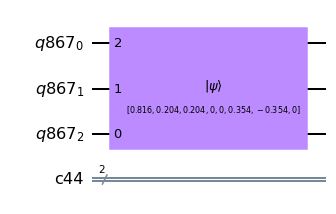

In [195]:
# sequencia: 000 001 010 011 100 101 110 111 = 0 1 2 3 4 5 6 7
Phi_ACD = [math.sqrt(2/3), (1/4)*math.sqrt(2/3), (1/4)*math.sqrt(2/3), 0,
           0, (1/4)*math.sqrt(2), -(1/4)*math.sqrt(2), 0]
qr = QuantumRegister(3); cr = ClassicalRegister(2); qc = QuantumCircuit(qr,cr)
qc.initialize(Phi_ACD, [qr[2],qr[1],qr[0]])
qc.draw(output='mpl')

In [176]:
backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
qc_state

array([ 0.81649658+8.88178420e-16j,  0.        +0.00000000e+00j,
        0.20412415+3.19189120e-16j, -0.35355339-4.16333634e-16j,
        0.20412415+4.85722573e-16j,  0.35355339+3.46944695e-16j,
        0.        +0.00000000e+00j,  0.        +0.00000000e+00j])

In [168]:
sqrt(2/3), 0.25*sqrt(2/3), 0.25*sqrt(2.)

In [159]:
state_fidelity(Phi_ACD,qc_state)

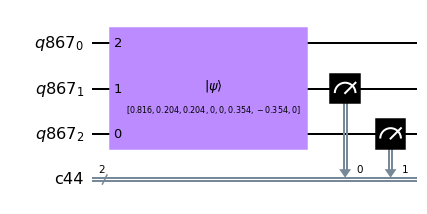

In [196]:
qc.measure([1,2],[0,1])
qc.draw(output='mpl')

In [197]:
job_sim = execute(qc, backend = simulator, shots = nshots)
job_exp = execute(qc, backend = device, shots = nshots)
job_monitor(job_exp)

Job Status: job has successfully run


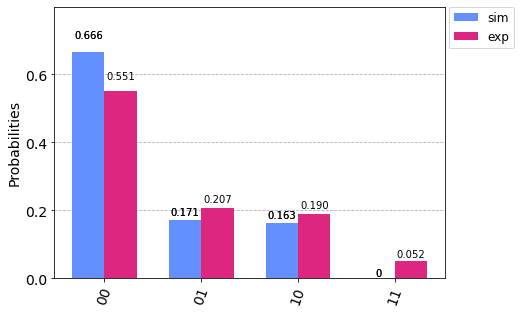

In [198]:
# tava dando errado o resultado. Me parece que na inicializacao a ordem dos qubits foi trocada
plot_histogram([job_sim.result().get_counts(), job_exp.result().get_counts()], 
                legend = ['sim', 'exp'])

##### Exercício
Analogamente ao que fizemos para $n=2$ e $n=3$, faça os cálculos (analíticos e possivelmente numéricos), simulação e implemente experimentalmente no IBMQ o seguinte exemplo de medida geral em um qubit com $n=4$ elementos:
\begin{align}
M_{1} = a|0\rangle\langle 0|, \\
M_{2} = b|+\rangle\langle +|, \\
M_{3} = c|1\rangle\langle 1|, \\
M_{4} = d|-\rangle\langle -|, 
\end{align}
com $|\pm\rangle = (|0\rangle\pm|1\rangle)/\sqrt{2}$. Novamente, esta POVM pode ser associada com estados $\{|\psi(0,0)\rangle,|\psi(\pi/2,0)\rangle,|\psi(\pi,0)\rangle,|\psi(3\pi/2,0)\rangle$, separados sequencialmente por um ângulo $\pi/2$ no plano $xz$ da esfera de Bloch. Primeiramente, verifique que é possível usarmos
\begin{equation}
a=b=c=d=\frac{1}{\sqrt{2}}.
\end{equation}
Implemente o circuito quântico com ângulos de sua escolha (eles não precisam estar relacionados com esse conjunto de M's). Implemente esse conjunto de M's usando o algoritmo baseado em inicialização de estados.

_SOL._ Vamos usar a relação de completeza:
\begin{align}
\mathbb{I} & = M_{1}^{\dagger}M_{1} + M_{2}^{\dagger}M_{2} + M_{3}^{\dagger}M_{3} + M_{4}^{\dagger}M_{4} \\
& = a^{2}|0\rangle\langle 0| + b^{2}|+\rangle\langle +| + c^{2}|1\rangle\langle 1| + d^{2}|-\rangle\langle -| \\
& = a^{2}|0\rangle\langle 0| + \frac{b^{2}}{2}(|0\rangle+|1\rangle)(\langle 0|+\langle 1|) + c^{2}|1\rangle\langle 1| + \frac{d^{2}}{2}(|0\rangle-|1\rangle)(\langle 0|-\langle 1|) \\
& = a^{2}|0\rangle\langle 0| + \frac{b^{2}}{2}(|0\rangle\langle 0|+|1\rangle\langle 0|+|0\rangle\langle 1|+|1\rangle\langle 1|) \\
& + c^{2}|1\rangle\langle 1| + \frac{d^{2}}{2}(|0\rangle\langle 0|-|1\rangle\langle 0|-|0\rangle\langle 1|+|1\rangle\langle 1|) \\
& = a^{2}|0\rangle\langle 0| + \frac{b^{2}}{2}(|0\rangle\langle 0|+|1\rangle\langle 1|) + c^{2}|1\rangle\langle 1| + \frac{b^{2}}{2}(|0\rangle\langle 0|+|1\rangle\langle 1|) \\
\end{align}
em que fizemos
\begin{equation}
d = b.
\end{equation}

Devemos ter portanto
\begin{align}
& b^{2}+c^{2} = 1 \ \therefore\ b^{2}=1-c^{2} \ \therefore\ b = \sqrt{1-c^{2}}, \\
& b^{2}+a^{2} = 1 \ \therefore\ 1-c^{2}+a^{2} = 1 \ \therefore\ c = a:=1/\sqrt{2}, \\
& \therefore\ b  = \sqrt{1-c^{2}}= \sqrt{1-1/2} = \sqrt{1/2} \ \therefore\ d = \sqrt{1/2}.
\end{align}

Usaremos novamente como estado inicial do sistema $A$ o vetor
\begin{equation}
|\psi\rangle_{A} = |0\rangle_{A}.
\end{equation}
Com relação às probabilidades, teremos
\begin{align}
& Pr(M_{1}|0_{A}) = _{A}\langle 0|M_{1}^{\dagger}M_{1}|0\rangle_{A} = a^{2}|\langle 0|0\rangle|^{2} = 1/2, \\
& Pr(M_{2}|0_{A}) = _{A}\langle 0|M_{2}^{\dagger}M_{2}|0\rangle_{A} = b^{2}|\langle 0|+\rangle|^{2} = (1/2)(1/2)=1/4, \\
& Pr(M_{3}|0_{A}) = _{A}\langle 0|M_{3}^{\dagger}M_{3}|0\rangle_{A} = c^{2}|\langle 0|1\rangle|^{2} = 0, \\
& Pr(M_{4}|0_{A}) = _{A}\langle 0|M_{4}^{\dagger}M_{4}|0\rangle_{A} = d^{2}|\langle 0|-\rangle|^{2} = (1/2)(1/2)=1/4.
\end{align}

O estado global é
\begin{align}
|\Phi\rangle_{AB} = & M_{1}|0\rangle_{A}\otimes|0\rangle_{B} + M_{2}|0\rangle_{A}\otimes|1\rangle_{B} + M_{3}|0\rangle_{A}\otimes|2\rangle_{B} + M_{4}|0\rangle_{A}\otimes|3\rangle_{B} \\
= & \sqrt{1/2}|0\rangle_{A}\otimes|0\rangle_{B} + \sqrt{1/2}\langle +|0\rangle|+\rangle_{A}\otimes|1\rangle_{B} + \sqrt{1/2}\langle 1|0\rangle|1\rangle_{A}\otimes|2\rangle_{B} + \sqrt{1/2}\langle -|0\rangle|-\rangle_{A}\otimes|3\rangle_{B} \\
= & \sqrt{1/2}|0\rangle_{A}\otimes|0\rangle_{B} + (1/2\sqrt{2})(|0\rangle_{A}+|1\rangle_{A})\otimes|1\rangle_{B} \\
& + 0 + (1/2\sqrt{2})(|0\rangle_{A}-|1\rangle_{A})\otimes|3\rangle_{B} \\
= & \sqrt{1/2}|0\rangle_{A}\otimes|0\rangle_{B} + (1/2\sqrt{2})|0\rangle_{A}\otimes|1\rangle_{B}  + (1/2\sqrt{2})|1\rangle_{A}\otimes|1\rangle_{B} \\
& + (1/2\sqrt{2})|0\rangle_{A}\otimes|3\rangle_{B} - (1/2\sqrt{2})|1\rangle_{A}\otimes|3\rangle_{B}.
\end{align}
Como aqui temos 4 estados do sistema auxiliar, usaremos 2 qubits com a equivalência
\begin{align}
& |0\rangle_{B} \rightarrow |00\rangle_{CD}, \\
& |1\rangle_{B} \rightarrow |01\rangle_{CD}, \\
& |2\rangle_{B} \rightarrow |10\rangle_{CD}, \\
& |3\rangle_{B} \rightarrow |11\rangle_{CD}.
\end{align}

Com isso, implementaremos o estado
\begin{align}
|\Phi\rangle_{ACD} = & \sqrt{1/2}|0\rangle_{A}\otimes|00\rangle_{CD} + (1/2\sqrt{2})|0\rangle_{A}\otimes|01\rangle_{CD}  + (1/2\sqrt{2})|1\rangle_{A}\otimes|01\rangle_{CD} \\
& + (1/2\sqrt{2})|0\rangle_{A}\otimes|11\rangle_{CD} - (1/2\sqrt{2})|1\rangle_{A}\otimes|11\rangle_{CD}.
\end{align}
Pode-se verificar novamente a correspondência:
\begin{align}
& Pr(M_{1}|0_{A}) = Pr(00_{CD}|\Phi_{ACD}) = 1/2, \\
& Pr(M_{2}|0_{A}) = Pr(01_{CD}|\Phi_{ACD}) = 1/4, \\
& Pr(M_{3}|0_{A}) = Pr(10_{CD}|\Phi_{ACD}) = 0, \\
& Pr(M_{4}|0_{A}) = Pr(11_{CD}|\Phi_{ACD}) = 1/4.
\end{align}

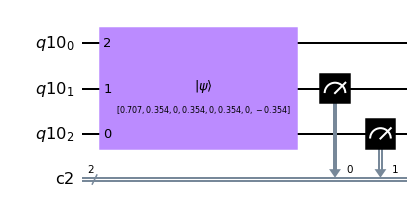

In [7]:
# sequencia: 000 001 010 011 100 101 110 111 = 0 1 2 3 4 5 6 7
Phi_ACD = [1/math.sqrt(2), 1/(2*math.sqrt(2)), 0, 1/(2*math.sqrt(2)), 
           0, 1/(2*math.sqrt(2)), 0, -1/(2*math.sqrt(2))]
qr = QuantumRegister(3); cr = ClassicalRegister(2); qc = QuantumCircuit(qr,cr)
qc.initialize(Phi_ACD, [qr[2],qr[1],qr[0]])
qc.measure([1,2],[0,1])
qc.draw(output='mpl')

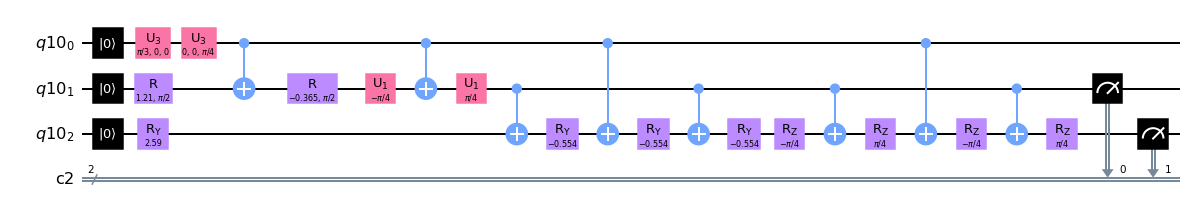

In [12]:
qc.decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

In [191]:
job_sim = execute(qc, backend = simulator, shots = nshots)
job_exp = execute(qc, backend = device, shots = nshots)
job_monitor(job_exp)

Job Status: job has successfully run


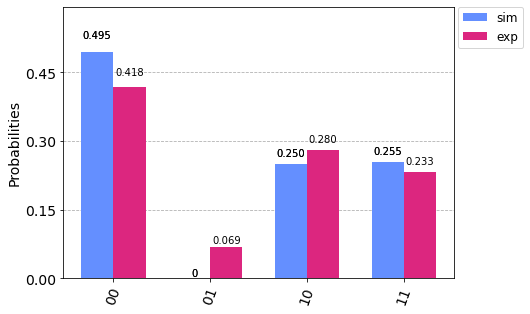

In [192]:
plot_histogram([job_sim.result().get_counts(), job_exp.result().get_counts()], 
                legend = ['sim', 'exp'])

Por fim, vamos montar o circuito quântico. Já vemos aqui que o algoritmo da referência básica usa um qubit a mais que o algoritmo introduzido aqui, no caso de um POVM com 4 elementos.

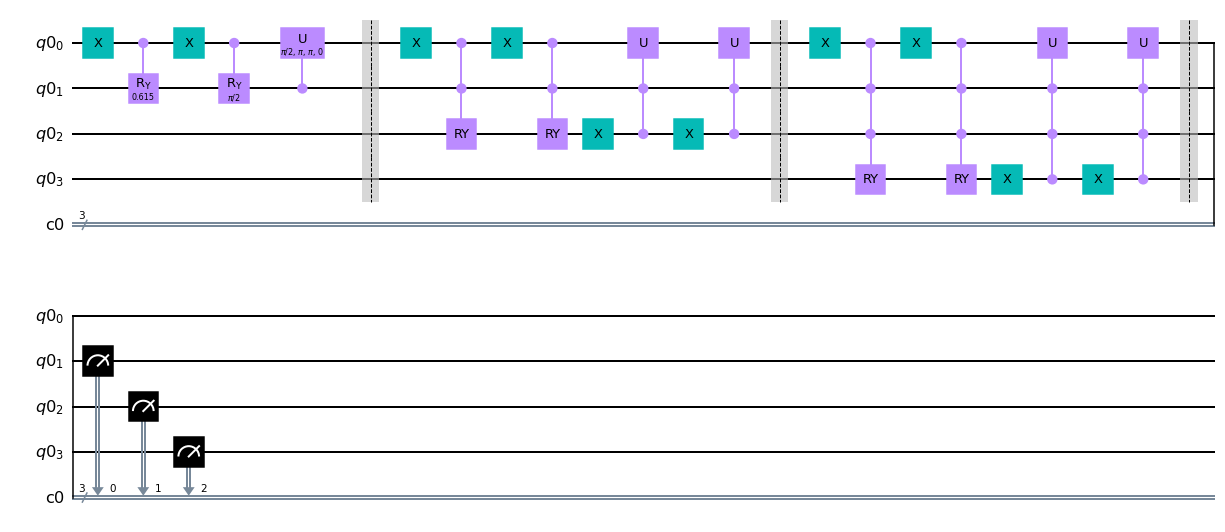

In [5]:
qr = QuantumRegister(4); cr = ClassicalRegister(3); qc = QuantumCircuit(qr, cr)
# U = I
qc.x(qr[0]); qc.cry(math.acos(math.sqrt(2/3)), 0, 1); qc.x(qr[0]); qc.cry(math.pi/2, 0, 1)
# V11 = I
qc.cu(math.pi/2,math.pi,math.pi,0, 1,0)
qc.barrier()
qc_ry_ = qc_ry(0); ccry = qc_ry_.to_gate().control(2) # cria a ctrl-ctrl-RY
qc.x(0); qc.append(ccry, [0,1,2]); qc.x(0)
qc_ry_ = qc_ry(math.pi/2); ccry = qc_ry_.to_gate().control(2)
qc.append(ccry, [0,1,2]) # os primeiros sao o controle, os ultimos sao o target
qc.x(2)
qc_u_ = qc_u(2*math.pi/3,0,0); ccu = qc_u_.to_gate().control(2)
qc.append(ccu, [1,2,0])
qc.x(2)
qc_u_ = qc_u(4*math.pi/3,0,0); ccu = qc_u_.to_gate().control(2)
qc.append(ccu, [1,2,0])
qc.barrier()
qc_ry_ = qc_ry(math.pi); cccry = qc_ry_.to_gate().control(3) # cria a ctrl-ctrl-ctrl-RY
qc.x(0); qc.append(cccry, [0,1,2,3]); qc.x(0)
qc_ry_ = qc_ry(math.pi/2); cccry = qc_ry_.to_gate().control(3)
qc.append(cccry, [0,1,2,3])
qc_u_ = qc_u(math.pi,0,0); cccu = qc_u_.to_gate().control(3)
qc.x(3); qc.append(cccu, [3,2,1,0]); qc.x(3)
qc.append(cccu, [3,2,1,0])
qc_u_ = qc_u(math.pi/3,0,0); cccu = qc_u_.to_gate().control(3)
qc.barrier()
qc.measure(1,0); qc.measure(2,1); qc.measure(3,2)
qc.draw(output = 'mpl')

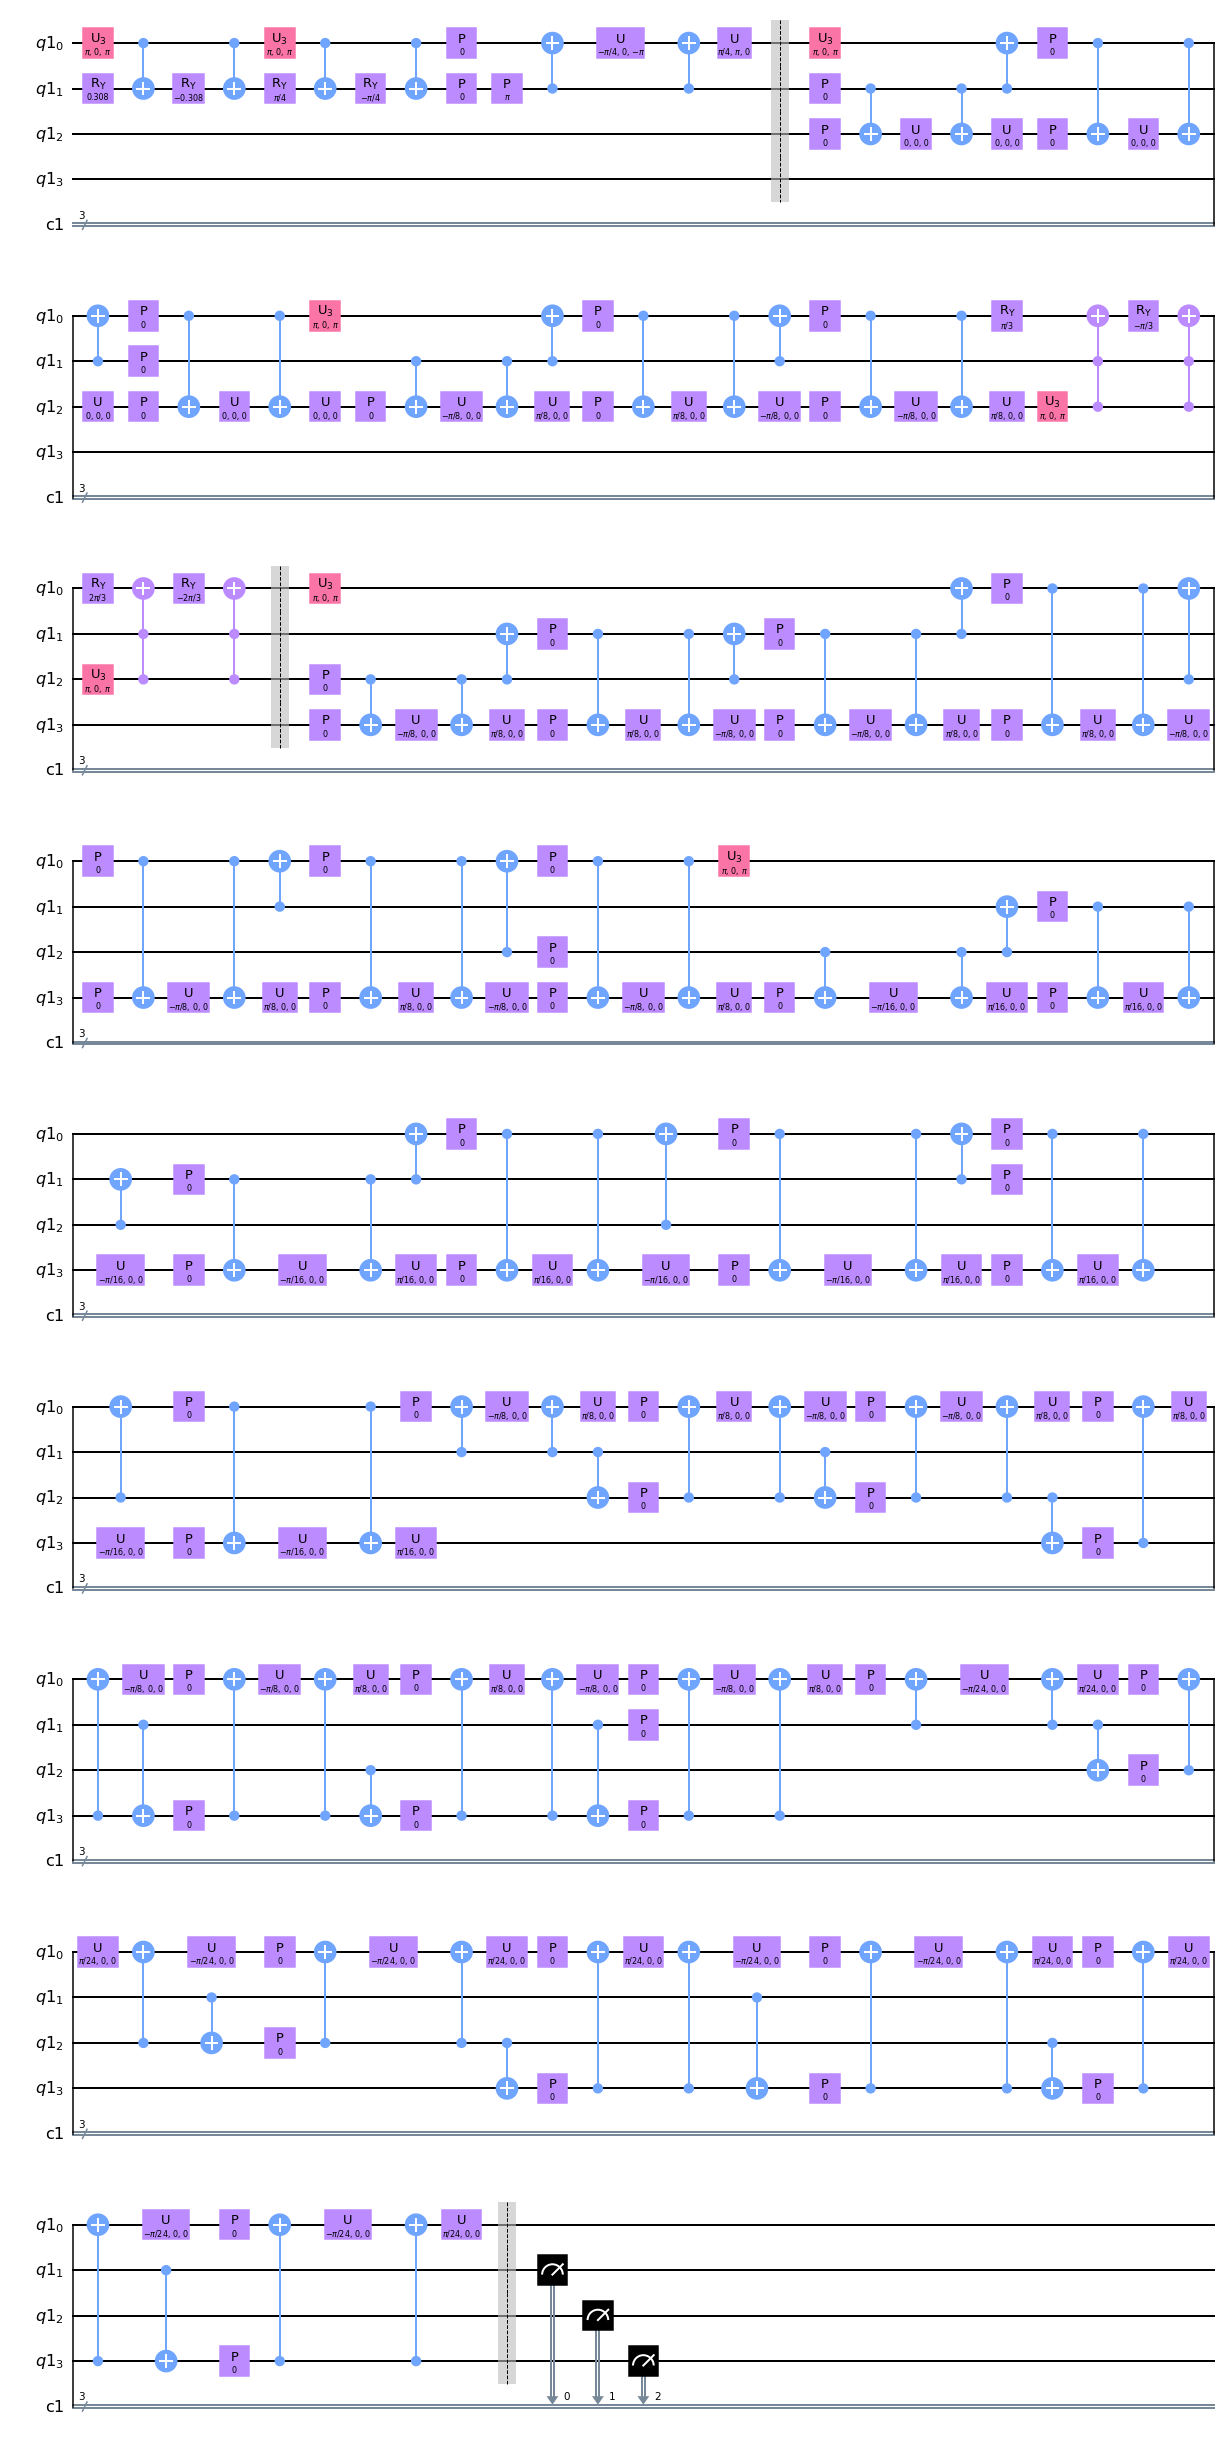

In [7]:
qc.decompose().draw(output = 'mpl')

# Testes para o comment

In [1]:
%run init.ipynb

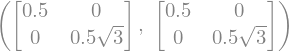

In [19]:
# 2 element 1-qubit povm (Yordanov)
M1 = (1/2)*Matrix([[1,0],[0,sqrt(3)]]); M2 = M1
M1, M2

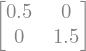

In [20]:
M1.T*M1 + M2.T*M2

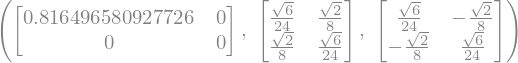

In [21]:
# 3 element 1-qubit povm (Yordanov)
M1 = sqrt(2/3)*Matrix([[1,0],[0,0]])
M2 = (1/(4*sqrt(6)))*Matrix([[1,sqrt(3)],[sqrt(3),1]])
M3 = (1/(4*sqrt(6)))*Matrix([[1,-sqrt(3)],[-sqrt(3),1]])
M1,M2,M3

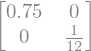

In [22]:
M1.T*M1 + M2.T*M2 + M3.T*M3

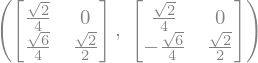

In [23]:
# 2-element 1-qubit POVM (Douglas)
M1 = (1/(2*sqrt(2)))*Matrix([[1,0],[sqrt(3),2]])
M2 = (1/(2*sqrt(2)))*Matrix([[1,0],[-sqrt(3),2]])
M1,M2

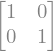

In [24]:
M1.T*M1 + M2.T*M2

## Estados mistos

Para estados puros, implementamos um POVM com operadores de medida $\{M_j\}$ preparando o estado
$$V_{AB}|\psi\rangle_A \otimes|0\rangle_B = \sum_j M_j|\psi\rangle_A \otimes|j\rangle_B = |\Phi\rangle_{AB},$$
medindo o sistema auxiliar na base $\{|j\rangle_B\}$, pós-selecionando o resultado dessa medida e ignorando $B$.

Consideremos agora que o estado do sistema é misto
$$\rho_A = \sum_j r_j |r_j\rangle_A\langle r_j|.$$
Este estado tem como uma purificação ($\rho_A = Tr_B(|\Psi\rangle_{AB}\langle\Psi|)$) o estado
$$|\Psi\rangle_{AB} = \sum_j \sqrt{r_j}|r_j\rangle_A \otimes|j\rangle_B.$$

Agora, extendendo o algoritmo para simulação de POVMs aplicados em estados puros, prepararmos o estado puro
$$V_{ABC}|\Psi\rangle_{AB}\otimes|0\rangle_C = \sum_j M_j \otimes\mathbb{I}_B|\Psi\rangle_{AB}\otimes|j\rangle_C = |\Phi\rangle_{ABC}.$$
Fazendo um medida na base $\{|j\rangle_C\}$, pós-selecinando o resultado e ignorando $C$ teremos implementado o POVM em $\rho_A$ pois
\begin{align}
& Tr_B\big(M_j \otimes\mathbb{I} |\Psi\rangle_{AB}\langle\Psi|M_j^\dagger \otimes\mathbb{I}\big) \\
& = Tr_B\big(M_j \otimes\mathbb{I} \sum_k \sqrt{r_k}|r_k\rangle_A \otimes|k\rangle_C \sum_l \sqrt{r_l}\langle r_l|_A \otimes\langle l|_C M_j^\dagger \otimes\mathbb{I}\big) \\
& =  \sum_{k,l}\sqrt{r_k r_l}Tr_B\big(M_j|r_k\rangle_A\langle r_l|M_j^\dagger \otimes|k\rangle_C\langle l|\big) \\
& =  \sum_{k,l}\sqrt{r_k r_l}M_j|r_k\rangle_A\langle r_l|M_j^\dagger \otimes\delta_{l,k} \\
& =  \sum_{k}r_k M_j|r_k\rangle_A\langle r_k|M_j^\dagger \\
& =  M_j\sum_{k}r_k|r_k\rangle_A\langle r_k|M_j^\dagger \\
& =  M_j \rho_A M_j^\dagger.
\end{align}

Por conseguinte, para
\begin{align}
|\Phi\rangle_{ABC} & = \sum_j M_j \otimes\mathbb{I}_B \sum_k \sqrt{r_k}|r_k\rangle_A \otimes |k\rangle_B \otimes|j\rangle_C \\
& = \sum_{j,k}\sqrt{r_k} (M_j|r_k\rangle_A) \otimes |kj\rangle_{BC},
\end{align}
teremos
$$|\Phi\rangle_{ABC} \xrightarrow[]{|j\rangle_C} \frac{M_j \otimes\mathbb{I}_B|\Psi\rangle_{AB}}{||M_j \otimes\mathbb{I}_B|\Psi\rangle_{AB}||} \xrightarrow[]{Tr_B} \frac{M_j \rho_A M_j^\dagger}{Tr(M_j \rho_A M_j^\dagger)}.$$